### Data Challenge 2022
## Team 
Gkountoumas Filippos <br>
Legkas Sotiris <br>
Papadopoulos Nikolaos



#### Imports/Installs

In [ ]:
#Library Installs
%matplotlib inline
!pip install -q gdown
!pip install -q unidecode
!pip install -q stellargraph

#Library Imports
import re
import os
import csv
import gzip
import io
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import math
import time
import nltk
import pickle
import zipfile
import requests
import warnings
import unidecode
import numpy as np
import unicodedata
import pandas as pd
import networkx as nx
import seaborn as sns
import urllib.request
from io import BytesIO
import tensorflow as tf
import stellargraph as sg
import scipy.sparse as sp
from tensorflow import keras
from keras.layers import LSTM
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
warnings.filterwarnings("ignore")
from stellargraph.layer import GCN
from tensorflow.keras import Model
from sklearn.metrics import f1_score
from nltk import WhitespaceTokenizer
import tensorflow.keras.backend as K
from stellargraph import StellarGraph
from nltk.stem import WordNetLemmatizer
from stellargraph.layer import GraphSAGE
from sklearn.dummy import DummyClassifier
from IPython.display import display, HTML
from sklearn.metrics import roc_auc_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from stellargraph.data import BiasedRandomWalk
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import precision_recall_curve
from sklearn import preprocessing, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import PredefinedSplit
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from stellargraph.mapper import FullBatchNodeGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, Embedding
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Embedding, Input
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix, recall_score, precision_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir("./")
os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['.config',
 'test.txt',
 'domains.zip',
 'node_embeddings.csv',
 'edgelist.txt',
 'DataStemmed.csv',
 'train.txt',
 'drive',
 'sample_data']

In [ ]:
#We've saved the pre-processed text so we don't have to run it every time as it takes a long time.We download the files from google drive then implement them to our code

!gdown 1yHyHl5D5PAC3J05xFYFk6wGsLfs-4jat
!gdown 162aSfvFARsaI06FAZWiquk3f5RhN-dRM
!gdown 1f2kn380eOWeNVYQDN1XjRddT-StbO3Yk
!gdown 19vPYOi89bMOMYQEByU92Ehw2qdSpIOdp
!gdown 1cXoUzx0v8Pvrrw6Zx461bOxVTkmCKLoG
!gdown 1gxr_CBf_Gw6G2_Cbp7dqo26lXWpZE6yb

Downloading...
From: https://drive.google.com/uc?id=1yHyHl5D5PAC3J05xFYFk6wGsLfs-4jat
To: /content/train.txt
100% 19.6k/19.6k [00:00<00:00, 19.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=162aSfvFARsaI06FAZWiquk3f5RhN-dRM
To: /content/test.txt
100% 7.83k/7.83k [00:00<00:00, 6.37MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f2kn380eOWeNVYQDN1XjRddT-StbO3Yk
To: /content/domains.zip
100% 831M/831M [00:05<00:00, 145MB/s]
Downloading...
From: https://drive.google.com/uc?id=19vPYOi89bMOMYQEByU92Ehw2qdSpIOdp
To: /content/edgelist.txt
100% 53.3M/53.3M [00:00<00:00, 70.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cXoUzx0v8Pvrrw6Zx461bOxVTkmCKLoG
To: /content/node_embeddings.csv
100% 250M/250M [00:02<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gxr_CBf_Gw6G2_Cbp7dqo26lXWpZE6yb
To: /content/DataStemmed.csv
100% 1.55G/1.55G [00:14<00:00, 108MB/s] 


#### Setting up our Data

In [ ]:
# Read training data
train_domains = list()
y_train = list()
with open("/content/drive/MyDrive/DataChallenge/train.txt", 'r') as f:
    for line in f:
        l = line.split(',')
        train_domains.append(l[0])
        y_train.append(l[1][:-1])

# Read test data
test_domains = list()
with open("/content/drive/MyDrive/DataChallenge/test.txt", 'r') as f:
    for line in f:
        l = line.split(',')
        test_domains.append(l[0])

In [ ]:
#Create Source-Target dataframe needed from edgelist.txt
dfgraph = pd.read_csv('/content/drive/MyDrive/DataChallenge/edgelist.txt',delimiter=' ',header=None,names=["source","target"])

In [ ]:
# Create a directed graph to read the files below
G = nx.read_edgelist('/content/drive/MyDrive/DataChallenge/edgelist.txt', delimiter=' ', create_using=nx.DiGraph())
node_to_idx = dict()
for i, node in enumerate(G.nodes()):
    node_to_idx[node] = i

In [ ]:
# Read textual content of webpages of domain names
text = dict()
with zipfile.ZipFile('/content/drive/MyDrive/DataChallenge/domains.zip', "r") as zfile:
    for filename in zfile.namelist():
        if re.search(r'\.zip$', filename) is not None:
            zfiledata = BytesIO(zfile.read(filename))
            with zipfile.ZipFile(zfiledata) as zfile2:
                text[filename[:-4]] = ''
                for name2 in zfile2.namelist():
                    file = zfile2.read(name2)
                    text[filename[:-4]] += file.decode('utf16') + ' '

idx = [node_to_idx[domain] for domain in text]
datas = [text[domain] for domain in text] # datas not data

In [ ]:
sites=[domain for domain in text]
#sites not in train or test
random_sites=[]
for i in sites:
    if i not in test_domains and i not in train_domains:
      #Gathering up every website that has text but that is not in test or train
        random_sites.append(i)

In [ ]:
# Create a dictionary that maps train and test domains to their textual content
# Domains for which no textual content is available are mapped to some special string
text_data = dict()

for domain in train_domains:
    if domain in text:
        text_data[domain] = text[domain]
    else:
        text_data[domain] = 'no_str'

for domain in test_domains:
    if domain in text:
        text_data[domain] = text[domain]
    else:
        text_data[domain] = 'no_str'

In [ ]:
# Create a dictionary that maps the extra domains to their textual content
random_text = dict()
for domain in random_sites:
        random_text[domain] = text[domain]

In [ ]:
#Collecting all text
test_text = []
for i in range(len(test_domains)):
  test_text.append(text_data[test_domains[i]])

In [ ]:
#Collecting all text
extra_text = []
for i in range(len(random_sites)):
  extra_text.append(random_text[random_sites[i]])

In [ ]:
#Creating a dataframe containing all training data
newdf = pd.DataFrame()
newdf["site"] = train_domains
newdf["text"] = text
newdf["category"] = y_train
newdf

ValueError: ignored

In [ ]:
newdftest=pd.DataFrame()

In [ ]:
#Creating a dataframe containing all test data
newdftest["site"] = test_domains
newdftest["text"] = test_text

In [ ]:
#Concatenating the above two dataframes
newdftest = pd.concat([newdf,newdftest], axis=0).reset_index(drop=True)

In [ ]:
#Creating a dataframe containing all the extra website text
newdfextra=pd.DataFrame()
newdfextra["site"] = random_sites
newdfextra["text"] = extra_text

In [ ]:
#Concatenating them with our previous dataframe
newdftest = pd.concat([newdftest,newdfextra], axis=0).reset_index(drop=True)

In [ ]:
#Filling na values
newdftest.fillna('no_str', inplace=True)

In [ ]:
#Checking that everything is fine
newdftest

In [ ]:
#To reduce memory 
text = None

#### Pre-processing Text Procedure

In [ ]:
#Init lemmatizer
lemmzer = WordNetLemmatizer() 
def prep_lowercase(s): 
    return s.lower()

In [ ]:
#Downloading Stopwords & Dictionary
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('greek')) 


def stop_word_func(x):
    filtered_sentence = []
    for w in word_tokenize(x):
          if w not in stop_words:
                  filtered_sentence.append(w)

    return filtered_sentence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# #Stemmer
# !pip install -q greek-stemmer-pos
# from greek_stemmer import stemmer

In [ ]:
#Preprocessing Function
def prep(corpus):
    corpus= corpus.apply(lambda x:re.sub(r'http\S+', '', x))#Remove html tags
    corpus= corpus.apply(lambda x:re.sub(r'<.*?>', ' ', x)) #Remove punctuation
    corpus= corpus.apply(lambda x:re.sub('\d+', ' ', x)) #Remove numbers
    return corpus

In [ ]:
def prep2(corpus):
    corpus = corpus.apply(lambda x:prep_lowercase(x))#Lowercase Data
    corpus = corpus.apply(lambda x:stop_word_func(x))#Filter out Stopwords
    return corpus

In [ ]:
def prep3(corpus):
        corpus= corpus.apply(lambda x:re.sub(r'\b[α-ω]{1,3}\b', '', x)) # remove words three letters and below
        corpus= corpus.apply(lambda x: re.sub(r'\W', ' ', str(x))) #Remove any symbols
        corpus= corpus.apply(lambda x:re.sub(r'\s+', ' ',x)) #Remove multiple spaces
        return corpus

In [ ]:
def prep4 (corpus):
    corpus= corpus.apply(lambda x:[stemmer.stem_word(word, 'VBG') for word in x.split()]) #Stemming
    return corpus 

In [ ]:
def prep5 (corpus):
    corpus= corpus.apply(lambda x:' '.join(x)) #Re-forming the previously split sentences
    corpus= corpus.apply(lambda x:re.sub(r'\b[α-ω]{1,2}\b', '', x)) #Remove words that are two letters or less which were created from Stemming
    return corpus 

In [ ]:
X_train.text =prep1(X_train.text)
X_train.text =prep2(X_train.text)
X_train.text =prep3(X_train.text)
X_train.text =prep4(X_train.text)
X_train.text = prep5(X_train.text)

#### Getting final text dataframe

In [ ]:
#Reading final dataframe from the google drive
X_train = pd.read_csv('/content/drive/MyDrive/DataChallenge/DataStemmed.csv')

In [ ]:
#Dropping a column and fillina na values
X_train = X_train.drop(['Unnamed: 0'],axis=1)
X_train.text = X_train.text.fillna('no_str')

In [ ]:
#We've decided to keep a certain number of words per text
for i in range(len(X_train.text)):
  if len(X_train.text[i].split())>3000:
    X_train.text[i]=' '.join(X_train.text[i].split()[:3000])

#### Word Embeddings+SVD

In [ ]:
# #Download and get stopwords
# !wget -nc http://archive.aueb.gr:8085/files/stopwords.txt
# f = open("stopwords.txt", "r")
# stopwords=[]
# while(True):
# 	#read next line
# 	line = f.readline()
# 	#if line is empty, you are done with all lines in the file
# 	if not line:
# 		break
# 	#you can access the line
# 	stopwords.append(line.strip())

# #close file
# f.close

In [ ]:
# #Vocabulary Size based on min and and max frequency of each word
# vectorizer = TfidfVectorizer( 
#     sublinear_tf = True,
#     min_df=100,max_df=300,
#     stop_words=stopwords
#     )

In [ ]:
# #Transforming all text datasets
# x_train_tfidf = vectorizer.fit_transform(X_train.text)

# # get_feauture_names() for vocabulary
# names=vectorizer.get_feature_names()

In [ ]:
# x_train_tfidf=None
# vectorizer=None

# #Print size of vocabulary
# print(len(names))

In [ ]:
# #Keep from only from text the words in the vocabulary
# text_final=[]
# for i in range(len(X_train.text)):
#   temp=[]
#   print(i)
#   for j in range(len(X_train.text[i].split())):
#     if X_train.text[i].split()[j] in names:
#       temp.append(X_train.text[i].split()[j])
#   text_final.append(' '.join(temp))

In [ ]:
# final=pd.DataFrame(text_final)

In [ ]:
# #Download and Unzip Greek Embeddings
# !wget -nc http://archive.aueb.gr:8085/files/grcorpus_def.vec.gz
# !gzip -d grcorpus_def.vec.gz

In [ ]:
# #Create Embeddings Model
# from gensim.models import KeyedVectors

# fasttext = KeyedVectors.load_word2vec_format('grcorpus_def.vec')

In [ ]:
# #Tokenize each text
# nltk.download('punkt')
# import nltk
# token=[nltk.word_tokenize(sent) for sent in final[0]]

In [ ]:
# #Calculate centroid function for embeddings

# import numpy as np

# def text_centroid(text, model):
#     text_vec =[]
#     counter = 0
#     for word in text: 
#       try:
#         if counter == 0:
#           text_vec = model[word.lower()]
#         else:
#           text_vec = np.add(text_vec, model[word.lower()])
#         counter+=1
#       except:
#         pass
    
#     return (np.asarray(text_vec) / counter)

In [ ]:
# #Create the embeddings for each domain
# X_train_centroids = []
# for i in range(len(token)):
#   if len(token[i])==1:
#     X_train_centroids.append(np.asarray([0 for i in range(300)]))
#   else:
#     X_train_centroids.append(text_centroid(token[i],fasttext))   
#   print(i)

In [ ]:
# X_train_centroids=pd.DataFrame(X_train_centroids)

In [ ]:
# fasttext=None
# token=None

In [ ]:
# #Fill NAs
# X_train_centroids.fillna('0.0',inplace=True)

In [ ]:
# #Use SVD to reduce dimensionality
# svd = TruncatedSVD(n_components=150)
# X_train_centroids = svd.fit_transform(X_train_centroids)
# X_train_centroids = pd.DataFrame(X_train_centroids)

In [ ]:
# #Concatanate domains with embeddings
# horizontal_stack = pd.concat([X_train,X_train_centroids],axis=1)
# horizontal_stack = horizontal_stack.drop(['text'],axis=1)
# horizontal_stack = horizontal_stack.drop(['category'],axis=1)

In [ ]:
# #Find domains without text
# test=[]
# for i in pd.unique(dfgraph[['source', 'target']].values.ravel('K')):
#   if i not in horizontal_stack.site.tolist():
#     test.append(i)
# test = pd.DataFrame(test,columns=['site'])

In [ ]:
# #Concatanate the domains without text
# horizontal_stack = pd.concat([horizontal_stack,test], axis=0).reset_index(drop=True)

In [ ]:
# horizontal_stack =  horizontal_stack.set_index("site")

In [ ]:
# #Fill NAs
# horizontal_stack.fillna('0.0',inplace=True)

####TFIDF+SVD

In [ ]:
#Vocabulary Size
vectorizer = TfidfVectorizer( 
    sublinear_tf = True,
    min_df=50,
    max_df=300
    )

In [ ]:
#Transforming all text datasets
x_train_tfidf = vectorizer.fit_transform(X_train.text.astype('U'))

In [ ]:
#Running an svd on our tfidf matrix
svd = TruncatedSVD(n_components=128)
x_train_tfidf = svd.fit_transform(x_train_tfidf)

In [ ]:
#Creating a dataframe out of that matrix
x_train_tfidf = pd.DataFrame(x_train_tfidf)

In [ ]:
#Concatenating the 2 dataframes
horizontal_stack = pd.concat([X_train,x_train_tfidf],axis=1)
horizontal_stack = horizontal_stack.drop(['text'],axis=1)
horizontal_stack = horizontal_stack.drop(['category'],axis=1)
horizontal_stack

,site,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,kollintzas.gr,0.072662,-0.009557,-0.028585,-0.011985,0.011205,-0.025275,0.006074,-0.043224,0.029014,...,0.033631,0.010721,0.013655,-0.029708,0.040736,0.009818,-0.002487,0.003741,-0.038098,-0.035080
1,naxos.gr,0.075943,-0.008829,0.054714,0.015289,-0.004465,0.058722,0.004902,-0.024381,-0.027587,...,0.010781,0.030460,0.034632,0.003788,0.004336,-0.004801,0.016937,0.019652,-0.003459,-0.005713
2,auth.gr,0.057425,-0.008291,-0.020086,-0.007058,0.000556,0.004087,0.005300,-0.014624,-0.003662,...,-0.007611,-0.003491,0.005186,-0.014352,-0.002023,0.009378,0.006078,0.004449,0.003123,-0.004599
3,kappoutel.gr,0.049468,-0.002489,0.056557,-0.013528,0.053283,-0.059153,0.001069,-0.007126,-0.118090,...,0.012181,-0.027511,0.035698,0.011682,0.023041,0.018398,-0.044501,0.047842,0.058016,-0.002644
4,ilioupoli.gr,0.084352,-0.008319,-0.015764,-0.009549,0.016280,-0.022937,0.004562,-0.027724,0.022683,...,-0.012570,0.005996,-0.022468,-0.003823,-0.003425,0.015651,0.023627,0.001565,-0.021444,-0.008029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40841,zyrinis.gr,0.093804,-0.014588,-0.007501,-0.001767,-0.017518,0.020422,-0.002923,0.003237,-0.017594,...,0.004691,0.009887,0.008919,0.003005,-0.006322,-0.003128,-0.006114,0.000865,0.006893,-0.001457
40842,zythognosia.gr,0.052377,-0.005290,0.026027,0.004013,-0.004854,0.023479,0.005309,-0.021604,0.002593,...,-0.002143,0.000499,-0.000881,-0.003432,-0.010691,-0.008418,0.008238,-0.000581,0.028415,-0.004003
40843,zythos.gr,0.022158,-0.000534,0.016749,0.004064,-0.003292,0.014173,0.003705,-0.010900,-0.003574,...,-0.026580,-0.031886,0.030881,-0.065083,-0.044172,0.027423,-0.005891,-0.004388,-0.001536,-0.009922
40844,zzdot.gr,0.044973,0.000478,-0.001105,-0.011400,0.017881,-0.026780,0.003312,-0.026628,-0.005605,...,-0.013263,0.006602,-0.017940,-0.020143,0.023789,0.005042,0.015908,0.015172,0.006971,0.004823


In [ ]:
#Creating a list that has all the other websites that have no text so we can add them to the final dataframe
test=[]
for i in pd.unique(dfgraph[['source', 'target']].values.ravel('K')): #For every unique website
    #If not already in our dataframe
    if i not in horizontal_stack.site.tolist():
      #Append it
        test.append(i)
test = pd.DataFrame(test,columns=['site'])

In [ ]:
#Concatenating the two dataframes
horizontal_stack = pd.concat([horizontal_stack,test], axis=0).reset_index(drop=True)
#Creating a list of all sites
all_sites = horizontal_stack.site
#Setting website names as index
horizontal_stack =  horizontal_stack.set_index("site")
#Filling NA values
horizontal_stack.fillna('0.0',inplace=True)

#### Node2Vec implementation

In [ ]:
# G = StellarGraph(
#     {"FinalBossDF": horizontal_stack}, {"Target/Source": dfgraph}
# )
# print(G.info())

# generator = FullBatchNodeGenerator(G, method="gcn")

In [ ]:
# rw = BiasedRandomWalk(G)

# walks = rw.run(
#     nodes=list(G.nodes()),  # root nodes
#     length=10,  # maximum length of a random walk
#     n=10,  # number of random walks per root node
#     p=1,  # Defines (unormalised) probability, 1/p, of returning to source node
#     q=0.5,  # Defines (unormalised) probability, 1/q, for moving away from source node
# )
# print("Number of random walks: {}".format(len(walks)))

In [ ]:
# from gensim.models import Word2Vec

# str_walks = [[n for n in walk] for walk in walks]
# model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=4, iter=10)

# node_ids = model.wv.index2word  # list of node IDs
# node_embeddings = (
#     model.wv.vectors
# )

In [ ]:
# node_2_vec_df = pd.read_csv('/content/drive/MyDrive/DataChallenge/3Node_Embeddings_True.15.15.1.05.csv',quoting = csv.QUOTE_NONNUMERIC,delimiter=',',header=None)

In [ ]:
# node_2_vec_df = pd.read_csv('/content/drive/MyDrive/DataChallenge/3Node_Embeddings_True.15.15.1.05.csv',quoting = csv.QUOTE_NONNUMERIC,delimiter=',')

In [ ]:
# node_2_vec_df
# node_2_vec_df = node_2_vec_df.set_index("site")

# horizontal_stack = pd.concat([horizontal_stack, node_2_vec_df], axis=1)

In [ ]:
# node_2_vec_df

In [ ]:
# # node_2_vec_df = pd.DataFrame(node_embeddings)

# node_2_vec_df = pd.concat([all_sites,node_2_vec_df], axis=1).reset_index(drop=True)

# node_2_vec_df = node_2_vec_df.set_index("site")

# node_2_vec_df = node_2_vec_df.add_prefix('n2v_')

# node_2_vec_df

# horizontal_stack = pd.concat([horizontal_stack, node_2_vec_df], axis=1)


In [ ]:
# horizontal_stack

In [ ]:
# node_2_vec_df.to_csv('3Node_Embeddings_True.15.15.1.05')

#### Model Building

In [ ]:
G = StellarGraph(
    {"FinalBossDF": horizontal_stack}, {"Target/Source": dfgraph}
)
print(G.info())

generator = FullBatchNodeGenerator(G, method="gcn")

StellarGraph: Undirected multigraph
 Nodes: 65208, Edges: 1642073

 Node types:
  FinalBossDF: [65208]
    Features: float32 vector, length 128
    Edge types: FinalBossDF-Target/Source->FinalBossDF

 Edge types:
    FinalBossDF-Target/Source->FinalBossDF: [1642073]
        Weights: all 1 (default)
        Features: none
Using GCN (local pooling) filters...


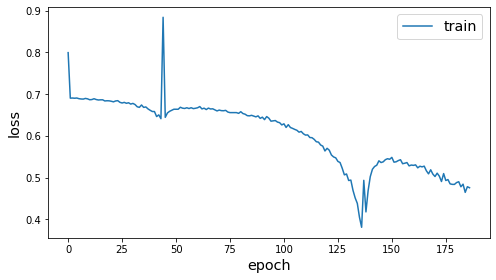

In [ ]:
#Deep Graph Infomax

from stellargraph.mapper import CorruptedGenerator, FullBatchNodeGenerator
from stellargraph.layer import GCN, DeepGraphInfomax
from tensorflow.keras import Model, layers, optimizers, callbacks

corrupted_generator = CorruptedGenerator(generator)
gen = corrupted_generator.flow(G.nodes())

def make_gcn_model():
    # function because we want to create a second one with the same parameters later
    return GCN(
        layer_sizes=[32,32],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )


pretrained_gcn_model = make_gcn_model()

infomax = DeepGraphInfomax(pretrained_gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

dgi_model = Model(inputs=x_in, outputs=x_out)
dgi_model.compile(
    loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=1e-2)
)

epochs = 1000

dgi_es = callbacks.EarlyStopping(monitor="loss", patience=50, restore_best_weights=True)

dgi_history = dgi_model.fit(gen, epochs=epochs, verbose=0, callbacks=dgi_es)

sg.utils.plot_history(dgi_history)

In [ ]:
# # Read training data
# train_domains = list()
# y_train = list()
# with open("/content/drive/MyDrive/DataChallenge/train.txt", 'r') as f:
#     for line in f:
#         l = line.split(',')
#         train_domains.append(l[0])
#         y_train.append(l[1][:-1])

# # Read test data
# test_domains = list()
# with open("/content/drive/MyDrive/DataChallenge/test.txt", 'r') as f:
#     for line in f:
#         l = line.split(',')
#         test_domains.append(l[0])

In [ ]:
#Changing Y values from 1 number to categorical
y_train = tf.keras.utils.to_categorical(y_train,num_classes=10, dtype='float32')

y_dev = tf.keras.utils.to_categorical(y_dev,num_classes=10, dtype='float32')

#Creating train and val gen so they can be fitted into our StellarGraph GCN
train_gen = generator.flow(x_train, y_train)
val_gen = generator.flow(x_dev,y_dev)

In [ ]:
#Initializing GCN with 2 layers of 32 units each
#Relu being the activation function for both(Both followed by a drop-out layer to avoid overfitting)
#Our last layer consists of 10 nodes(As many as our classes) and the activation function is a softmax so we get a
#probability distribution for the 10 classes.Loss is categorical crossentropy/Same as the loss calculated in the challenge
gcn = GCN(
    layer_sizes=[32,32], activations=["relu","relu"], generator=generator, dropout=0.5
)
pretrained_x_in, pretrained_x_out = pretrained_gcn_model.in_out_tensors()

predictions = layers.Dense(units=10, activation="softmax")(pretrained_x_out)

model = Model(inputs=pretrained_x_in, outputs=predictions)

model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=['acc']
)

#Initializing early-stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100,restore_best_weights=True)

In [ ]:
#Splitting
x_train,x_dev,y_train,y_dev = train_test_split(train_domains,y_train,stratify=y_train,random_state=0,test_size=0.2)

In [ ]:
# del model

In [ ]:
history = model.fit(
    train_gen,
    epochs=1000,
    validation_data=val_gen,
    shuffle=False,  # This should be False, since shuffling data means shuffling the whole graph
    callbacks=stop_early
)

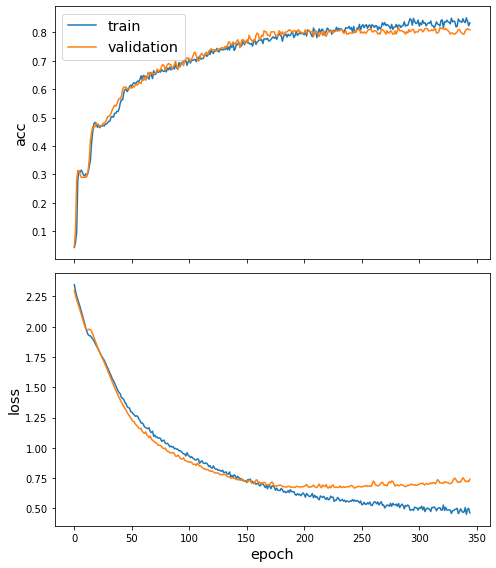

In [ ]:
# Make predictions
predict_gen = generator.flow(test_domains)
y_pred = model.predict(predict_gen)
sg.utils.plot_history(history)

In [ ]:
predict_val_gen = generator.flow(x_dev)
y_dev_pred2 = model.predict(predict_val_gen)
y_dev_pred2 = y_dev_pred2[0]

y_dev2=[]
for i in range(len(y_dev)):
  y_dev2.append(np.argmax(y_dev[i]))

y_dev_pred=[]
for i in range(len(y_dev_pred2)):
  y_dev_pred.append(np.argmax(y_dev_pred2[i]))

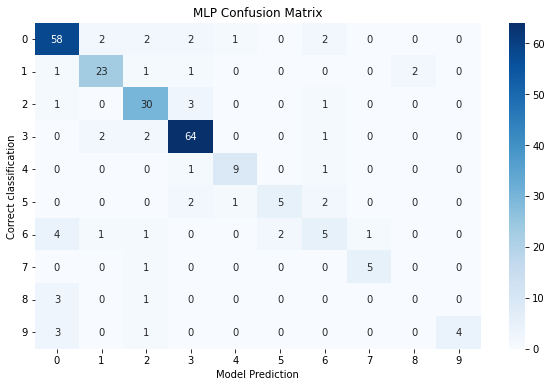

In [ ]:
mat = confusion_matrix(y_dev2, y_dev_pred)
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', cmap = 'Blues')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('MLP Confusion Matrix')
ax.xaxis.set_ticklabels(range(0,10))
ax.yaxis.set_ticklabels(range(0,10))
plt.yticks(rotation=0)
plt.show()

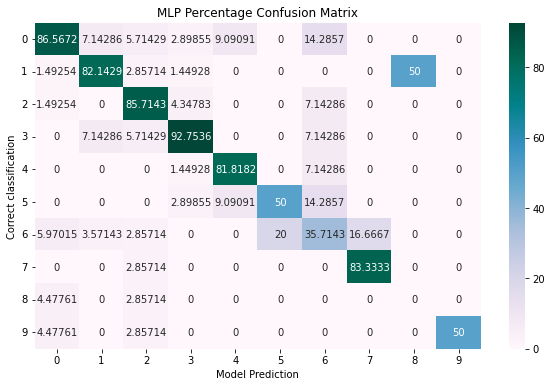

In [ ]:
mat_perc = 100*(mat / mat.sum(axis=1))
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat_perc, annot=True, fmt='g', cmap = 'PuBuGn')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('MLP Percentage Confusion Matrix')
ax.xaxis.set_ticklabels(range(0,10))
ax.yaxis.set_ticklabels(range(0,10))
plt.yticks(rotation=0)
plt.show()

In [ ]:
# Write predictions to a file
with open('Submisssss.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(10):
        lst.append('class_'+str(i))
    lst.insert(0, "domain_name")
    writer.writerow(lst)
    for i,test_host in enumerate(test_domains):
        lst = y_pred[0][i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)